In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 16*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Load the parameters

In [3]:
with open('turing_parameters.npy', 'rb') as f:
    turing_parameters = np.load(f)

with open('./outputs/indices.npy', 'rb') as f:
    indices = np.load(f)
    

In [4]:
def load_dataset(index):
    with open(f"./outputs/parameters_100_{index}.npy", "rb") as f:
        params = np.load(f)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
        
    with open(f"./outputs/full_solution_100_{index}.npy", "rb") as f:
        res_128_50 = np.load(f)
    with open(f"./outputs/full_solution_10_{index}.npy", "rb") as f:
        res_128_10= np.load(f)
    with open(f"./outputs/full_solution_1_{index}.npy", "rb") as f:
        res_128_1 = np.load(f)
    return (params, res_128_50, res_128_10, res_128_1)

1232


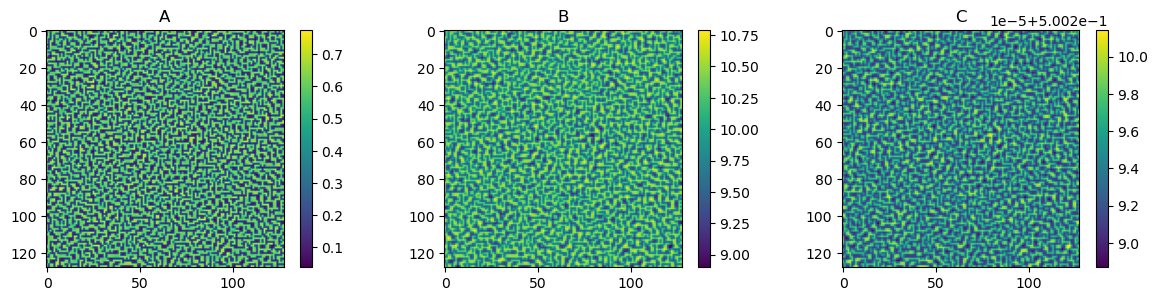

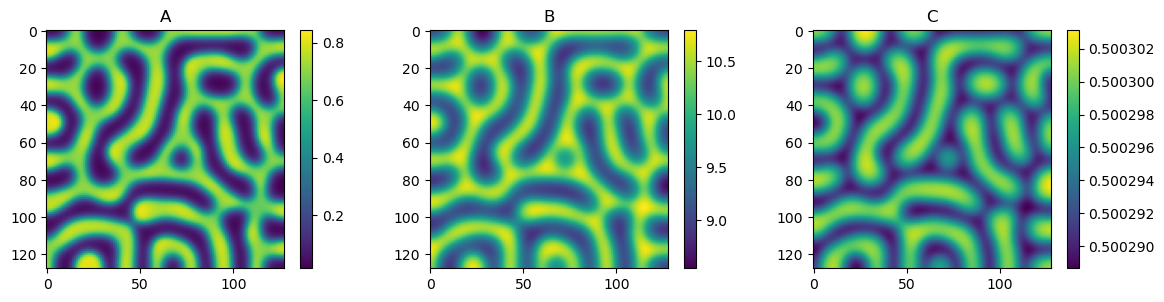

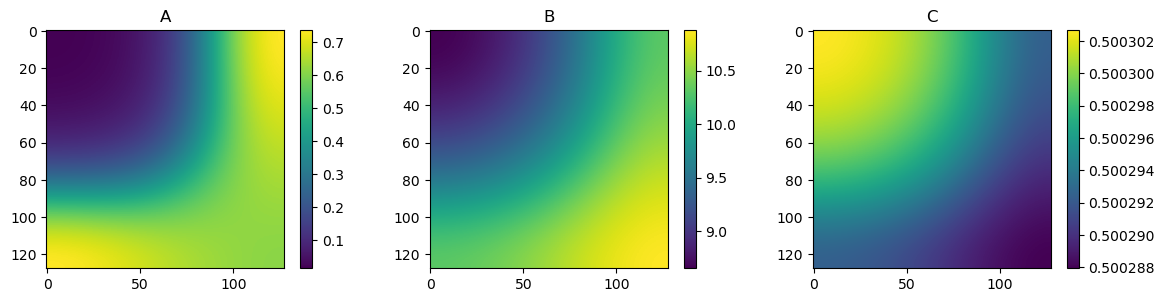

In [5]:
index = 2#2
print(indices[index])
(params, res_128_50, res_128_10, res_128_1) = load_dataset(indices[index])

def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)


plot_n_im([to(res_128_50[-1, 0, :]), to(res_128_50[-1, 1, :]), to(res_128_50[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_10[-1, 0, :]), to(res_128_10[-1, 1, :]), to(res_128_10[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_1[-1, 0, :]), to(res_128_1[-1, 1, :]), to(res_128_1[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [6]:
T=1
L=10
if L == 50:
    res = res_128_50
elif L == 10:
    res = res_128_10
elif L == 1:
    res = res_128_1

data = reshape(res, T)#res_128_1[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C"]
x_size = data.shape[1]
y_size = data.shape[2]
dxdy = L**2/((x_size-1)*(y_size-1))
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]


x_slice = slice(45, 100, 1)
y_slice = slice(45, 100, 1)

x_range = L * np.linspace(0, 1, x_size)[x_slice]
y_range = L * np.linspace(0, 1, y_size)[y_slice]

block_x = x_range.shape[0]
block_y = y_range.shape[0]

x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)


# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)

X, Y = tf.meshgrid(x, y)
ts = tf.constant(t_star, dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
def H_cube(X, Y, T):
    return tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )
H = H_cube(X, Y, T)

#      Periodic boundary condition
X_R = tf.concat([X[:, 1:] ,  X[:, 0:1]], axis=1)
X_L = tf.concat([X[:, -1:], X[:, :-1]], axis=1)
Y_D = tf.concat([Y[1:, :] ,  Y[0:1, :]], axis=0)
Y_U = tf.concat([ Y[1:, :], Y[0:1, :]], axis=0)


    
H_R = H_cube(X_R, Y, T)
H_L = H_cube(X_L, Y, T)
H_D = H_cube(X, Y_D, T)
H_U = H_cube(X, Y_U, T)


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])

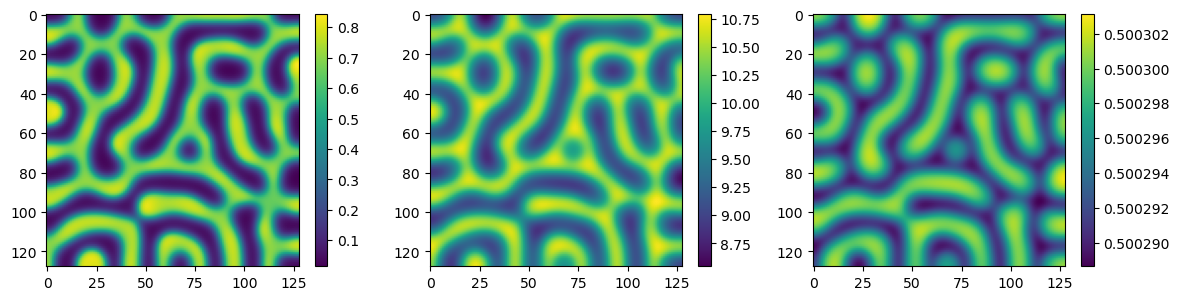

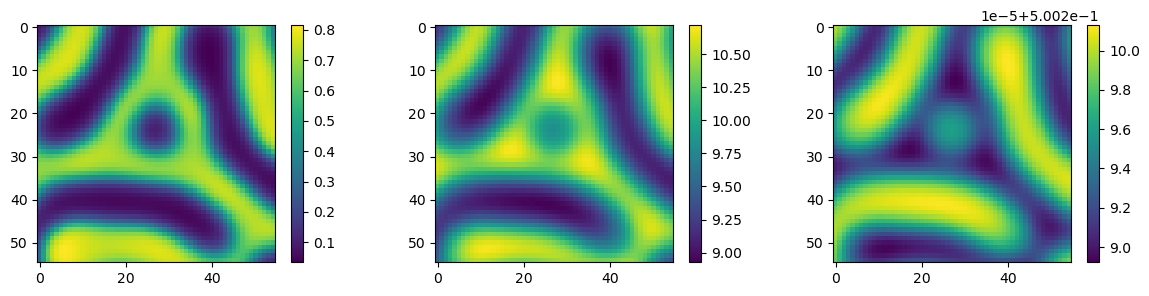

In [7]:
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [8]:
print(np.min(data[0, x_slice, y_slice, -1]), np.max(data[0, x_slice, y_slice, -1]))
print(np.min(data[1, x_slice, y_slice, -1]), np.max(data[1, x_slice, y_slice, -1]))
print(np.min(data[2, x_slice, y_slice, -1]), np.max(data[2, x_slice, y_slice, -1]))

0.03370782333236581 0.8158191948470113
8.926342734277082 10.721403520599122
0.5002892205940549 0.5003012949488828


In [9]:
c = data[:, x_slice, y_slice, :].copy()
def gen_series():    
    
    for i in range(H.shape[0]):        
        yield H[i, ...], np.einsum( "cxy -> xyc", c[..., i]) 
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((H.shape[1],H.shape[2], H.shape[3]),
                                                   (c.shape[1],c.shape[2], c.shape[0])))

In [11]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        if value is None:
            self.value = params[name]
        else:
            self.value = value
        self.is_constant = is_constant    
    

def create_pinn(layers=[3, 4*1024, 4*1024, 3],
                learning_rate=1e-2,
                w1=1, w2=1, w3=1, w4=1, w5=1, w6=1, w7=1, w8=1,
                D_A_val=tf_param("D_A"), D_B_val=tf_param("D_B"),
                b_A_val=tf_param("b_A"),b_B_val=tf_param("b_B"),b_C_val=tf_param("b_C"),
                V_A_val=tf_param("V_A"),V_B_val=tf_param("V_B"),V_C_val=tf_param("V_C"),
                mu_A_val=tf_param("mu_A"),mu_B_val=tf_param("mu_B"),mu_C_val=tf_param("mu_C"),
                K_AA_val=tf_param("K_AA"),K_AB_val=tf_param("K_AB"),K_AC_val=tf_param("K_AC"),
                K_BA_val=tf_param("K_BA"),K_BC_val=tf_param("K_BC"),
                K_CB_val=tf_param("K_CB"),K_CC_val=tf_param("K_CC"),
                n_val=tf_param("n")): 
    # Since there is just one time step, the lower bound is zero and the upper bound is one
    lb = tf.constant([x_range[0], y_range[0], 0], dtype=tf.float32)
    ub =  tf.constant([x_range[-1], y_range[-1], t_star[0]], dtype=tf.float32)
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    
    def create_tf_var(param, no_clip=False):
        print(f"{param.name}: {param.value}")
        if no_clip:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name)
        else:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name,
                               constraint=clip_by_value_zero_lb)
    
    D_A = create_tf_var(D_A_val)    
    D_B = create_tf_var(D_B_val)
    b_A = create_tf_var(b_A_val)#
    b_B = create_tf_var(b_B_val)#
    b_C = create_tf_var(b_C_val)#
    V_A = create_tf_var(V_A_val)
    V_B = create_tf_var(V_B_val)
    V_C = create_tf_var(V_C_val)
    mu_A = create_tf_var(mu_A_val)
    mu_B = create_tf_var(mu_B_val)
    mu_C = create_tf_var(mu_C_val)
    K_AA = create_tf_var(K_AA_val)
    K_AB = create_tf_var(K_AB_val)
    K_AC = create_tf_var(K_AC_val)
    K_BA = create_tf_var(K_BA_val)
    K_BC = create_tf_var(K_BC_val)
    K_CB = create_tf_var(K_CB_val)
    K_CC = create_tf_var(K_CC_val)
    n = create_tf_var(n_val)
                    
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
    w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")   
    w5 = tf.Variable(w1,dtype=pinn.dtype,name="w5")
    w6 = tf.Variable(w2,dtype=pinn.dtype,name="w6")
    w7 = tf.Variable(w3,dtype=pinn.dtype,name="w7")
    w8 = tf.Variable(w4,dtype=pinn.dtype,name="w8")   
                        
    def as_tuple(val, param):
        if val.is_constant:
            return ()
        else:
            return (param,)
    
    
    params_trainable =(
                      as_tuple(D_A_val, D_A)
                    + as_tuple(D_B_val, D_B)
                    + as_tuple(b_A_val, b_A)
                    + as_tuple(b_B_val, b_B)
                    + as_tuple(b_C_val, b_C)
                    + as_tuple(V_A_val, V_A)
                    + as_tuple(V_B_val, V_B)
                    + as_tuple(V_C_val, V_C)
                    + as_tuple(mu_A_val, mu_A)
                    + as_tuple(mu_B_val, mu_B)
                    + as_tuple(mu_C_val, mu_C)                    
                    + as_tuple(K_AA_val, K_AA)
                    + as_tuple(K_AB_val, K_AB)
                    + as_tuple(K_AC_val, K_AC)
                    + as_tuple(K_BA_val, K_BA)
                    + as_tuple(K_BC_val, K_BC)
                    + as_tuple(K_CB_val, K_CB)
                    + as_tuple(K_CC_val, K_CC)
                   )
    globals()["index"]=0

    @tf.function
    def train_step_inverse(elements):
        def flatten(arr):
            return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
        
        # Using VALID padding removes the boundaries
        #print(elements[1][..., 0:1].shape)
        act_A_laplacian = pinn.derivative_fields(elements[1][..., 0:1], padding="VALID")
        #print(act_A_laplacian.shape)
        act_A_laplacian = flatten(act_A_laplacian)
        #print(act_A_laplacian.shape)
        act_B_laplacian = pinn.derivative_fields(elements[1][..., 1:2], padding="VALID") 
        act_B_laplacian = flatten(act_B_laplacian)

        act_A_rhs = tf.squeeze(act_A_laplacian/(dxdy))
        act_B_rhs = tf.squeeze(act_B_laplacian/(dxdy))
        
        def to(arr):            
            return arr.numpy().reshape(53, 53)

        
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            # remove the boundaries
            H = H[:, 1:-1, 1:-1, :]
            H = flatten(H)
            tape.watch(H)
            trainables = pinn.trainable_variables + params_trainable

            outputs = pinn.net(H)
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])
            Cg = tf.squeeze(outputs[:, 2])

            grad_A = tape.gradient(Ag, H)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]

            grad_B = tape.gradient(Bg, H)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0]
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]

            H2 = elements[1]
            # remove the boundaries
            H2 = H2[:, 1:-1, 1:-1, :]
            H2 = flatten(H2)
            
            A = tf.squeeze(H2[:, 0])
            B = tf.squeeze(H2[:, 1])
            C = tf.squeeze(H2[:, 2])                

            def act(x, km, n=2):
                return 1 / (1 + (km / (x + 1e-20)) ** (n))

            def inh(x, km, n=2):
                return 1 / (1 + (x / (km + 1e-20)) ** (n))

            A_rhs =  (A_xx + A_yy)# - u_t
            B_rhs =  (B_xx + B_yy)# - v_t
            

            f_A =  b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - mu_A * A + D_A * A_rhs
            f_B =  b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - mu_B * B + D_B * B_rhs
            f_C =  b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C
            
            f_Ag =  b_A + V_A*act(Ag, K_AA, n)*inh(Bg, K_BA, n) - mu_A * Ag + D_A * A_rhs
            f_Bg =  b_B + V_B*act(Ag, K_AB, n)*inh(Cg, K_CB, n) - mu_B * Bg + D_B * B_rhs
            f_Cg =  b_C + V_C*inh(Ag, K_AC, n)*inh(Bg, K_BC, n)*act(Cg, K_CC, n) - mu_C * Cg
            
            l2_res_A = tf.reduce_sum(f_A**2)
            l2_res_B = tf.reduce_sum(f_B**2)
            l2_res_C = tf.reduce_sum(f_C**2) 
            
            l2_res_Ag = tf.reduce_sum(f_Ag**2)
            l2_res_Bg = tf.reduce_sum(f_Bg**2)
            l2_res_Cg = tf.reduce_sum(f_Cg**2) 

            l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
            l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


            l2 = (w1*l2_res_A + w2*l2_res_B + 
                  w3*l2_res_C +
                  w4*l2_res_A_rhs + w5*l2_res_B_rhs + 
                  w6*l2_res_Ag + w7*l2_res_Bg + 
                  w8*l2_res_Cg)
        
        grads = tape.gradient(l2, trainables)
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, 
                l2_res_C,  
                l2_res_A_rhs, l2_res_B_rhs,
                l2_res_Ag, l2_res_Bg, 
                l2_res_Cg
        )
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C',  
            'l2_res_A_rhs', 'l2_res_B_rhs',
            'l2_res_Ag', 'l2_res_Bg', 'l2_res_Cg']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w3, w4, w5, w6, w7, w8)

In [12]:
params

{'D_A': 0.01,
 'D_B': 1.0,
 'n': 4.0,
 'b_A': 0.001,
 'mu_A': 0.5,
 'V_A': 10.0,
 'K_AA': 0.5,
 'K_AB': 0.5,
 'K_AC': 5.0,
 'b_B': 0.1,
 'mu_B': 1.0,
 'V_B': 25.0,
 'K_BA': 5.0,
 'K_BC': 20.0,
 'b_C': 0.5,
 'mu_C': 1.0,
 'V_C': 50.0,
 'K_CB': 50.0,
 'K_CC': 10.0}

In [21]:
(pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
w1, w2, w3, w4, w5, w6, w7, w8) = create_pinn(learning_rate=1e-2,
D_A_val=tf_param("D_A",1 , False), D_B_val=tf_param("D_B", 1, False),
b_A_val=tf_param("b_A", 1, False),b_B_val=tf_param("b_B", 1, False),
                                  b_C_val=tf_param("b_C", 2, False),
V_A_val=tf_param("V_A", 15, False),V_B_val=tf_param("V_B", 30, False),
                                  V_C_val=tf_param("V_C", 90, False),
K_AA_val=tf_param("K_AA", 2, False),K_AB_val=tf_param("K_AB", 2, False),
K_AC_val=tf_param("K_AC", 2, False), K_BA_val=tf_param("K_BA", 1, False),
K_BC_val=tf_param("K_BC", 1, False), K_CB_val=tf_param("K_CB", 90, False),
K_CC_val=tf_param("K_CC", 2, False),       
#mu_A_val=tf_param("mu_A", 1, False),mu_B_val=tf_param("mu_B", 1, False),mu_C_val=tf_param("mu_C", 1, False),
w1=1, w2=1, w3=1, w4=100, w5=100
)

#(b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, mu_C) = params_trainable1
#(b_A, b_B, b_C, V_A, V_B, V_C) = params_trainable1
#(b_A, b_B, b_C, V_C) = params_trainable1
#(b_C, V_C) = params_trainable1

D_A: 1
D_B: 1
b_A: 1
b_B: 1
b_C: 2
V_A: 15
V_B: 30
V_C: 90
mu_A: 0.5
mu_B: 1.0
mu_C: 1.0
K_AA: 2
K_AB: 2
K_AC: 2
K_BA: 1
K_BC: 1
K_CB: 90
K_CC: 2
n: 4.0


In [17]:
epochs=10000+1
params_est = np.zeros((epochs, len(params_trainable1)))
def epoch_callback1(epoch, loss_samples, index):
    params_est[epoch, : ] = [item.numpy() for item in params_trainable1]

In [22]:
losses1 = tu.train(epochs=5000,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=200,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)
optimizer1.lr.assign(1e-3)
losses2 = tu.train(epochs=5000,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=200,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)
optimizer1.lr.assign(1e-4)
losses3 = tu.train(epochs=5000,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=200,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 517726.79443359375
l2_res_A: 1798.02661133, l2_res_B: 211448.23437500, l2_res_C: 6318.08105469, l2_res_A_rhs: 89925.86718750, l2_res_B_rhs: 191138.17187500, l2_res_Ag: 2842.40429688, l2_res_Bg: 2694.93286133, l2_res_Cg: 11561.07617188
D_A:0: 0.9900009632110596, D_B:0: 0.9899999499320984, b_A:0: 0.9899997711181641, b_B:0: 1.010000228881836, b_C:0: 1.989999771118164, V_A:0: 14.99001407623291, V_B:0: 30.010000228881836, V_C:0: 89.98999786376953, K_AA:0: 2.0099997520446777, K_AB:0: 1.989999771118164, K_AC:0: 1.9900094270706177, K_BA:0: 0.9900000095367432, K_BC:0: 0.9899997711181641, K_CB:0: 90.00115203857422, K_CC:0: 2.010000228881836
Time taken: 11.80s

Start of epoch 200
at epoch 200, total loss: 1272750.316652298
l2_res_A: 16365.15039062, l2_res_B: 84676.12500000, l2_res_C: 6241.97705078, l2_res_A_rhs: 62496.17187500, l2_res_B_rhs: 174229.28125000, l2_res_Ag: 927715.12500000, l2_res_Bg: 1022.28088379, l2_res_Cg: 4.20520210
D_A:0: 0.0, D_B:0: 0.2


Start of epoch 2400
at epoch 2400, total loss: 89443.32345473766
l2_res_A: 1971.26696777, l2_res_B: 388.48333740, l2_res_C: 4963.18994141, l2_res_A_rhs: 21646.09960938, l2_res_B_rhs: 58710.65625000, l2_res_Ag: 1338.49841309, l2_res_Bg: 424.81274414, l2_res_Cg: 0.31619155
D_A:0: 0.0, D_B:0: 0.011484158225357533, b_A:0: 1.0376685857772827, b_B:0: 9.185741424560547, b_C:0: 1.8293976783752441, V_A:0: 15.032302856445312, V_B:0: 29.67474365234375, V_C:0: 89.93441772460938, K_AA:0: 2.1114981174468994, K_AB:0: 1.4579802751541138, K_AC:0: 1.9344209432601929, K_BA:0: 1.0515974760055542, K_BC:0: 0.9343104958534241, K_CB:0: 89.93296813964844, K_CC:0: 2.0755035877227783
Time taken: 40.12s

Start of epoch 2600
at epoch 2600, total loss: 72001.84072685242
l2_res_A: 1613.65881348, l2_res_B: 411.47473145, l2_res_C: 4786.18701172, l2_res_A_rhs: 16269.00390625, l2_res_B_rhs: 46892.58593750, l2_res_Ag: 1423.03430176, l2_res_Bg: 602.38214111, l2_res_Cg: 3.51388359
D_A:0: 0.0, D_B:0: 0.007966870442032814, 


Start of epoch 4800
at epoch 4800, total loss: 41119.02320405841
l2_res_A: 1279.58752441, l2_res_B: 401.15756226, l2_res_C: 2658.11572266, l2_res_A_rhs: 3524.45239258, l2_res_B_rhs: 31349.99804688, l2_res_Ag: 1286.83569336, l2_res_Bg: 618.78967285, l2_res_Cg: 0.08658907
D_A:0: 0.0, D_B:0: 0.022465905174613, b_A:0: 0.8726792931556702, b_B:0: 9.173861503601074, b_C:0: 1.472875714302063, V_A:0: 15.032302856445312, V_B:0: 29.12676239013672, V_C:0: 89.93441772460938, K_AA:0: 2.150758981704712, K_AB:0: 1.427374243736267, K_AC:0: 1.9344221353530884, K_BA:0: 1.0519096851348877, K_BC:0: 0.9344308972358704, K_CB:0: 89.93296813964844, K_CC:0: 2.1015453338623047
Time taken: 40.38s

Start of epoch 0
at epoch 0, total loss: 39311.02205628902
l2_res_A: 1199.80419922, l2_res_B: 402.28723145, l2_res_C: 2464.32324219, l2_res_A_rhs: 2908.06005859, l2_res_B_rhs: 30434.67773438, l2_res_Ag: 1326.09960938, l2_res_Bg: 575.71856689, l2_res_Cg: 0.05141420
D_A:0: 0.0, D_B:0: 0.024828221648931503, b_A:0: 0.85111

at epoch 2200, total loss: 24931.23503603041
l2_res_A: 1128.35119629, l2_res_B: 367.14169312, l2_res_C: 2100.76806641, l2_res_A_rhs: 1073.49694824, l2_res_B_rhs: 18334.03125000, l2_res_Ag: 1206.48291016, l2_res_Bg: 720.85400391, l2_res_Cg: 0.10896792
D_A:0: 0.0, D_B:0: 0.025907116010785103, b_A:0: 0.8309255242347717, b_B:0: 9.175192832946777, b_C:0: 1.3650155067443848, V_A:0: 15.032302856445312, V_B:0: 28.89386749267578, V_C:0: 89.93441772460938, K_AA:0: 2.1658291816711426, K_AB:0: 1.4245349168777466, K_AC:0: 1.9344221353530884, K_BA:0: 1.0521140098571777, K_BC:0: 0.9341739416122437, K_CB:0: 89.93296813964844, K_CC:0: 2.113025426864624
Time taken: 40.34s

Start of epoch 2400
at epoch 2400, total loss: 24015.93387515098
l2_res_A: 1117.41955566, l2_res_B: 368.52969360, l2_res_C: 2048.55981445, l2_res_A_rhs: 920.76422119, l2_res_B_rhs: 17759.82031250, l2_res_Ag: 1146.00256348, l2_res_Bg: 654.72509766, l2_res_Cg: 0.11261661
D_A:0: 0.0, D_B:0: 0.027915621176362038, b_A:0: 0.8277629613876343


Start of epoch 4800
at epoch 4800, total loss: 13773.722912788391
l2_res_A: 889.57208252, l2_res_B: 437.21926880, l2_res_C: 1116.58435059, l2_res_A_rhs: 399.17645264, l2_res_B_rhs: 9336.74023438, l2_res_Ag: 935.77062988, l2_res_Bg: 643.60052490, l2_res_Cg: 15.05936909
D_A:0: 0.0, D_B:0: 0.04231224209070206, b_A:0: 0.758184552192688, b_B:0: 9.082283973693848, b_C:0: 1.130566954612732, V_A:0: 15.032302856445312, V_B:0: 28.388090133666992, V_C:0: 89.93441772460938, K_AA:0: 2.194817066192627, K_AB:0: 1.3698458671569824, K_AC:0: 1.9344221353530884, K_BA:0: 1.05274498462677, K_BC:0: 0.9336314797401428, K_CB:0: 89.93296813964844, K_CC:0: 2.1370491981506348
Time taken: 40.36s

Start of epoch 0
at epoch 0, total loss: 13107.471516728401
l2_res_A: 896.49060059, l2_res_B: 438.60198975, l2_res_C: 1036.75354004, l2_res_A_rhs: 426.01879883, l2_res_B_rhs: 8663.68164062, l2_res_Ag: 905.30554199, l2_res_Bg: 739.98864746, l2_res_Cg: 0.63075745
D_A:0: 0.0, D_B:0: 0.042308222502470016, b_A:0: 0.760428786


Start of epoch 2400
at epoch 2400, total loss: 11436.881915777922
l2_res_A: 861.83935547, l2_res_B: 443.68185425, l2_res_C: 880.06500244, l2_res_A_rhs: 329.21282959, l2_res_B_rhs: 7401.79199219, l2_res_Ag: 907.69512939, l2_res_Bg: 612.56066895, l2_res_Cg: 0.03508350
D_A:0: 0.0, D_B:0: 0.04465894028544426, b_A:0: 0.7490977644920349, b_B:0: 9.073678970336914, b_C:0: 1.0599756240844727, V_A:0: 15.032302856445312, V_B:0: 28.329559326171875, V_C:0: 89.93441772460938, K_AA:0: 2.206110954284668, K_AB:0: 1.3650404214859009, K_AC:0: 1.9344221353530884, K_BA:0: 1.0530997514724731, K_BC:0: 0.9334151744842529, K_CB:0: 89.93296813964844, K_CC:0: 2.146134614944458
Time taken: 40.31s

Start of epoch 2600
at epoch 2600, total loss: 11345.33608963713
l2_res_A: 857.17669678, l2_res_B: 445.51290894, l2_res_C: 859.34631348, l2_res_A_rhs: 325.65487671, l2_res_B_rhs: 7328.31640625, l2_res_Ag: 901.86865234, l2_res_Bg: 627.42614746, l2_res_Cg: 0.03408768
D_A:0: 0.0, D_B:0: 0.04504762217402458, b_A:0: 0.74755

D_A:0: 0.0, D_B:0: 0.04858045279979706, b_A:0: 0.7318288087844849, b_B:0: 9.052343368530273, b_C:0: 0.9452275633811951, V_A:0: 15.032302856445312, V_B:0: 28.246347427368164, V_C:0: 89.93441772460938, K_AA:0: 2.2281911373138428, K_AB:0: 1.355736494064331, K_AC:0: 1.9344221353530884, K_BA:0: 1.053934097290039, K_BC:0: 0.9330066442489624, K_CB:0: 89.93296813964844, K_CC:0: 2.1637909412384033
Time taken: 40.37s


In [22]:
print(params)

{'D_A': 0.01, 'D_B': 1.0, 'n': 4.0, 'b_A': 0.001, 'mu_A': 0.5, 'V_A': 10.0, 'K_AA': 0.5, 'K_AB': 0.5, 'K_AC': 5.0, 'b_B': 0.1, 'mu_B': 1.0, 'V_B': 25.0, 'K_BA': 5.0, 'K_BC': 20.0, 'b_C': 0.5, 'mu_C': 1.0, 'V_C': 50.0, 'K_CB': 50.0, 'K_CC': 10.0}


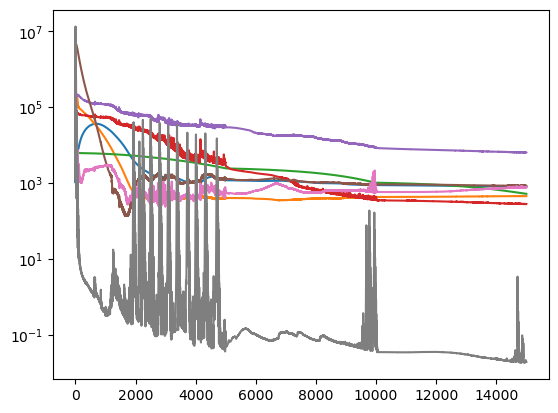

In [24]:
plt.plot(np.concatenate([losses1, losses2, losses3]))
plt.yscale('log')

In [ ]:
'D_A': 0.01, 'D_B': 1.0, 'b_A': 0.001, 'b_B': 0.1, 'b_C': 0.5, 
'V_A': 10.0, 'V_B': 25.0, 'V_C': 50.0,
'K_AA': 0.5, 'K_AB': 0.5, 'K_AC': 5.0, 'K_BA': 5.0, 
'K_BC': 20.0, 'K_CB': 50.0, 'K_CC': 10.0

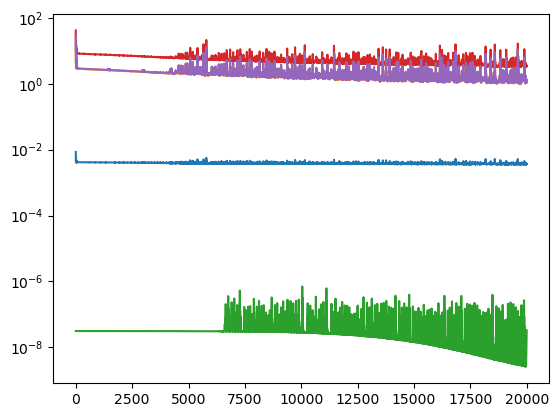

In [26]:
plt.plot(losses2)
plt.yscale('log')

In [27]:
(D_A_val, D_B_val, b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val,
 K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
 K_CB_val, K_CC_val ) = params_trainable1

In [28]:
(n_val, D_A_val, D_B_val,
 b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
 K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
 K_CB_val, K_CC_val ) = (params["n"], D_A_val, D_B_val,
                         b_A_val, b_B_val, b_C_val,
                         V_A_val, V_B_val, V_C_val,
                         params["mu_A"], params["mu_B"], params["mu_C"],
                         K_AA_val, K_AB_val, K_AC_val, 
                         K_BA_val, K_BC_val, 
                         K_CB_val, K_CC_val)

In [29]:
with open(f"./parameters_temp.npy", "wb") as f:
    np.save(f, (n_val, D_A_val, D_B_val,
                b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
                K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
                K_CB_val, K_CC_val))

In [29]:
c_xx =  np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[0]/dxdy 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[1]/dxdy 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

D_A = D_A_val#params["D_A"]
D_B = D_B_val#params["D_B"]

#c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

In [30]:
@tf.function
def grads(pinn, H):
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    
    with tf.GradientTape(persistent=True) as tape:
        # remove the boundaries
        H = H[:, :, :, :]
        H = flatten(H)
        tape.watch(H)
        
        outputs = pinn.net(H)
        Ag = tf.squeeze(outputs[:, 0])
        Bg = tf.squeeze(outputs[:, 1])
        #Cg = tf.squeeze(outputs[:, 2])
        

        grad_A = tape.gradient(Ag, H)
        A_x = grad_A[:, 0]
        A_y = grad_A[:, 1]
        A_t = grad_A[:, 2]

        grad_B = tape.gradient(Bg, H)
        B_x = grad_B[:, 0]
        B_y = grad_B[:, 1]
        B_t = grad_B[:, 2]


        grad_A_x = tape.gradient(A_x, H)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, H)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, H)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, H)
        B_yy = grad_B_y[:, 1]
        
        
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            #tf.squeeze(Cg)
           )                               



def plot_state(pinn):
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)

    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     #C, 
    ) = grads(pinn, H)

    A_der = D_A*( to(A_xx) + to(A_yy))
    B_der = D_B*( to(B_xx) + to(B_yy))

    actual_A_der = D_A*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
    actual_B_der = D_B*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
    # X and Y are misoriented
    #A_der = A_der
    #B_der = B_der

    plot_n_im([to(A), c[0,:, : , -1], to(B), c[1,:, :  , -1]], 
      ["A", "Actual A", "B", "Actual B"],          
      figsize=(12, 3)); plt.tight_layout()

    A = c[0,:, : , -1]
    B = c[1,:, : , -1]
    print(np.sum((A_der[1:-1,1:-1]-actual_A_der[1:-1,1:-1])**2))
    print(np.sum((B_der[1:-1,1:-1]-actual_B_der[1:-1,1:-1])**2))


    plot_n_im([to(A_xx)[1:-1,1:-1], c_xx[0,x_slice, y_slice , -1],
               to(A_yy)[1:-1,1:-1], c_yy[0,x_slice, y_slice  , -1]], 
      ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
      figsize=(12, 3)); plt.tight_layout()

    plot_n_im([to(B_xx)[1:-1,1:-1], c_xx[1,x_slice, y_slice  , -1], 
               to(B_yy)[1:-1,1:-1], c_yy[1,x_slice, y_slice  , -1]],
              ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
              figsize=(12, 3)); plt.tight_layout()
   # plot_n_im([to(A_t),  c_t[0,x_slice, y_slice , -1],  to(B_t),  c_t[1,x_slice, y_slice , -1]],
    #           ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
    #           figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
#                    ["Actual A_t",  "Actual B_t"],          
#                    figsize=(12, 3)); plt.tight_layout()
    plot_n_im([A_der[1:-1,1:-1],  actual_A_der[1:-1,1:-1]],
              ["RHS A", "Actual RHS A"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([B_der[1:-1,1:-1],  actual_B_der[1:-1,1:-1]],
              ["RHS B", "Actual RHS B"],          
              figsize=(12, 3)); plt.tight_layout()
    plt.show()

0.0
15.286199


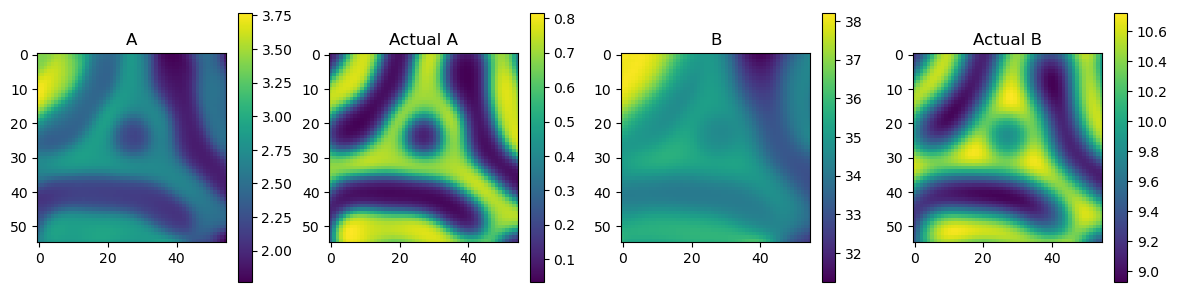

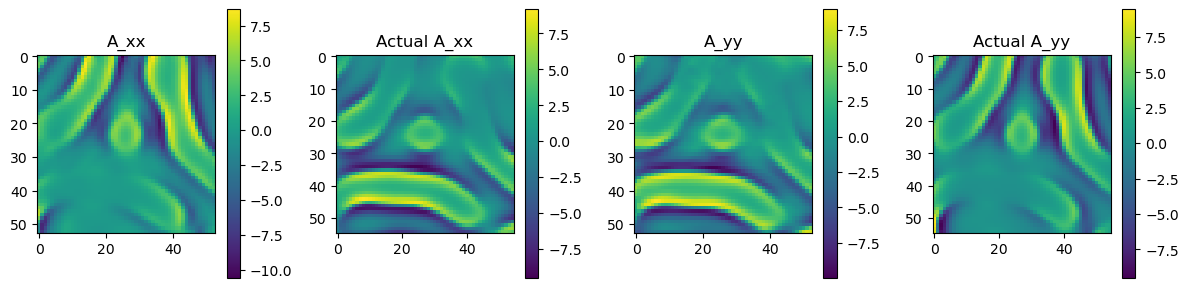

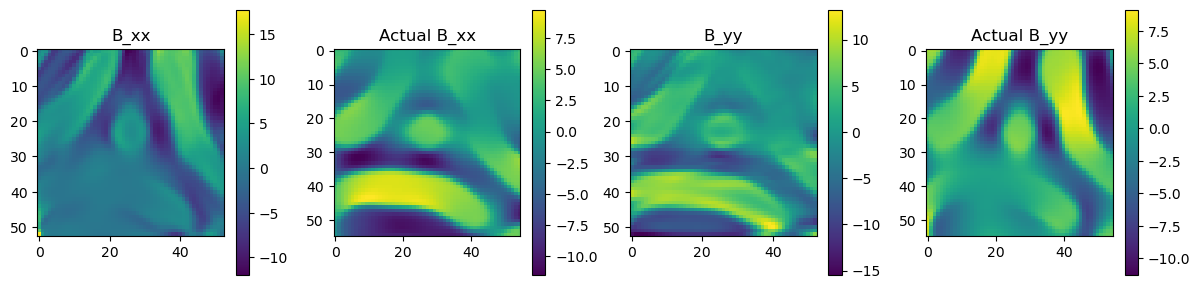

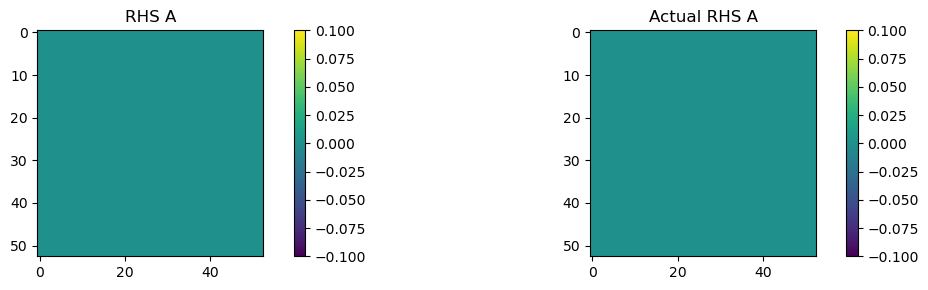

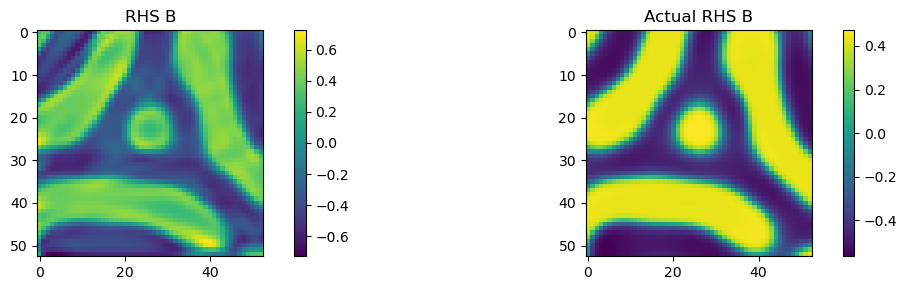

In [31]:
plot_state(pinn1)

In [48]:
def ratio(nom, dnom, n=2):
    return (nom / (dnom + 1e-20)) ** (n)
    
def act(x, km, n=2):
    return 1 / (1 + (km / (x + 1e-20)) ** (n))

def inh(x, km, n=2):
    return 1 / (1 + (x / (km + 1e-20)) ** (n))

A = c[0,:, : , -1]
B = c[1,:, : , -1]
C = c[1,:, : , -1]

# f_A =  b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - mu_A * A + A_rhs
# f_B =  b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - mu_B * B + B_rhs
# f_C =  b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C

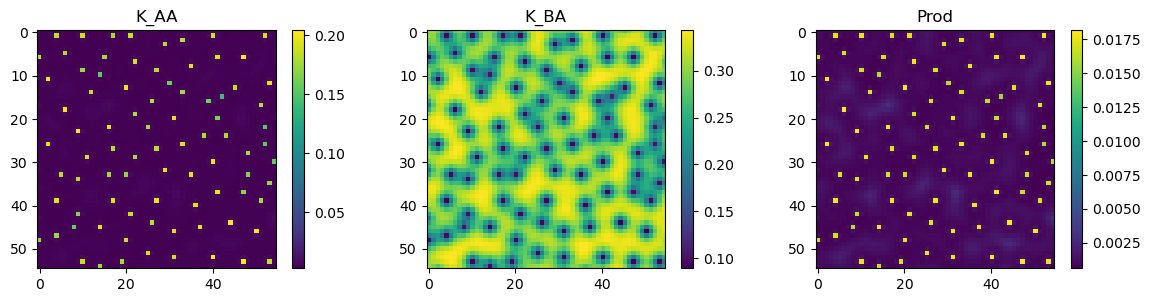

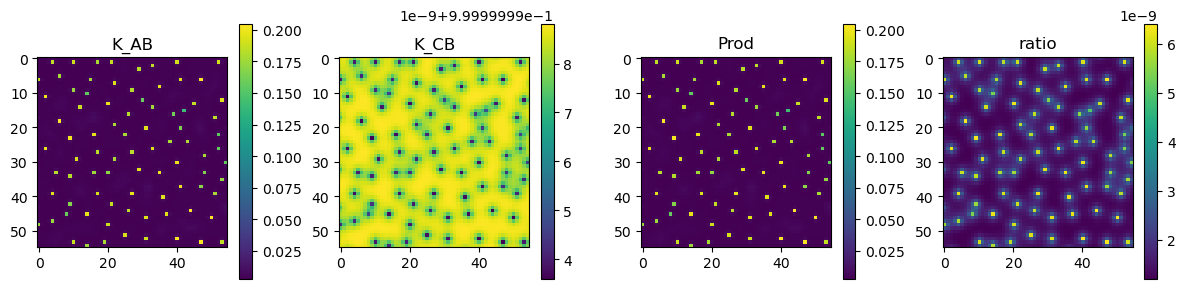

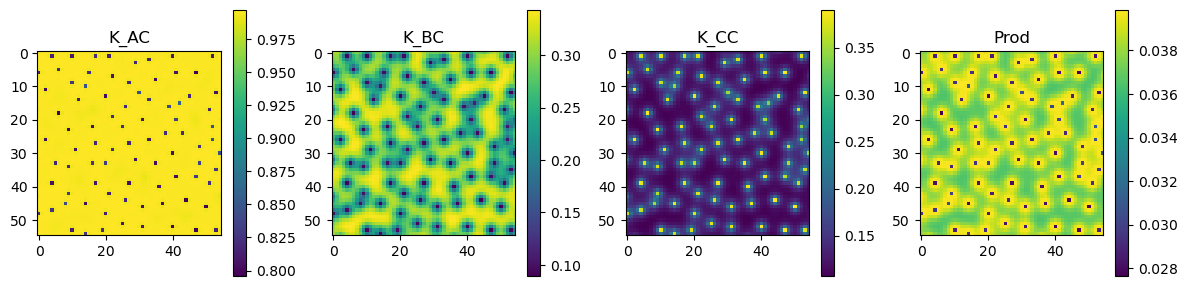

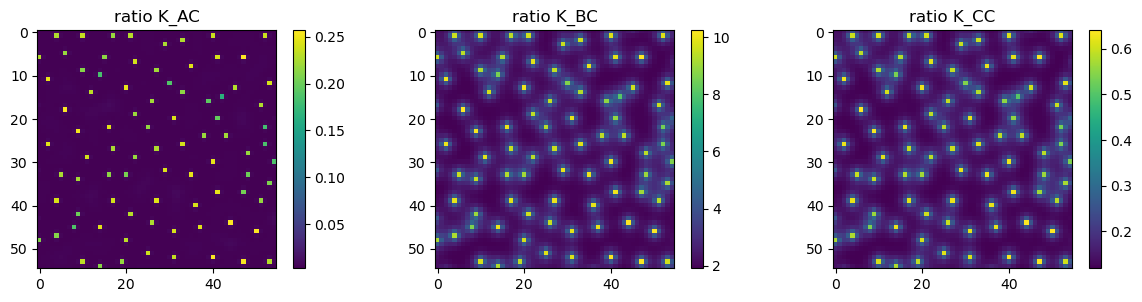

In [50]:
n = params["n"]
plot_n_im([act(A, params["K_AA"], n), inh(B, params["K_BA"], n), 
           act(A, params["K_AA"], n)*inh(B, params["K_BA"], n)],
          ["K_AA", "K_BA", "Prod"],          
              figsize=(12, 3)); plt.tight_layout()

plot_n_im([act(A, params["K_AB"], n), inh(C, params["K_CB"], n), 
           act(A, params["K_AB"], n)*inh(C, params["K_CB"], n), ratio(C, params["K_CB"], n)],
          ["K_AB", "K_CB", "Prod", "ratio"],          
              figsize=(12, 3)); plt.tight_layout()

plot_n_im([inh(A, params["K_AC"], n), inh(B, params["K_BC"], n), act(C, params["K_CC"], n),
           inh(A, params["K_AC"], n)*inh(B, params["K_BC"], n)*act(C, params["K_CC"], n)],
          ["K_AC", "K_BC", "K_CC", "Prod"],          
              figsize=(12, 3)); plt.tight_layout()

plot_n_im([ratio(A, params["K_AC"], n), ratio(B, params["K_BC"], n), ratio(C, params["K_CC"], n)],
          ["ratio K_AC", "ratio K_BC", "ratio K_CC"],
              figsize=(12, 3)); plt.tight_layout()